In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=2b50463cdd1d2f9ab8d2798592deb5b614cb8ed79c7b98b22f3a14cd83f0d611
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [3]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
# import glob

# celeb_df_fake = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_fake_face_only/*.mp4')
# celeb_df_real = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_real_face_only/*.mp4')
# kaggle_fake = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_FAKE_Face_only_data/*.mp4')
# kaggle_real = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_REAL_Face_only_data/*.mp4')
# ff_forensic = glob.glob('/content/drive/My Drive/Face_only_data/FF_Face_only_data/*.mp4')

# video_files = celeb_df_fake + celeb_df_real + kaggle_fake + kaggle_real + ff_forensic

In [4]:
import glob
import pandas as pd

# Step 1: Load the metadata
header_list = ["file", "label"]
metadata = pd.read_csv('/content/drive/My Drive/Face_only_data/Gobal_metadata.csv', names=header_list)

# Extract the list of valid filenames from the metadata
valid_filenames = set(metadata['file'].values)

# Step 2: Gather all video files from directories
celeb_df_fake = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_fake_face_only/*.mp4')
celeb_df_real = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_real_face_only/*.mp4')
kaggle_fake = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_FAKE_Face_only_data/*.mp4')
kaggle_real = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_REAL_Face_only_data/*.mp4')
ff_forensic = glob.glob('/content/drive/My Drive/Face_only_data/FF_Face_only_data/*.mp4')

unfiltered_video_files = celeb_df_fake + celeb_df_real + kaggle_fake + kaggle_real + ff_forensic

# Step 3: Filter out videos that are not listed in the metadata
video_files = [video for video in unfiltered_video_files if video.split('/')[-1] in valid_filenames]

# Print how many videos remain after filtering
print(f"Total valid video files: {len(video_files)}")


Total valid video files: 6449


In [5]:
len(video_files)

6449

In [6]:
import random

random.shuffle(video_files)

In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 100,transform = None ,im_size = 112 ):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
        self.im_size = im_size  # Add im_size as an attribute


    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
            image = cv2.resize(image, (self.im_size, self.im_size))  # Ensure uniform size
            yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [8]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Face_only_data/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake




train :  5159
test :  1290
TRAIN:  Real: 2627  Fake: 2532
TEST:  Real: 681  Fake: 609


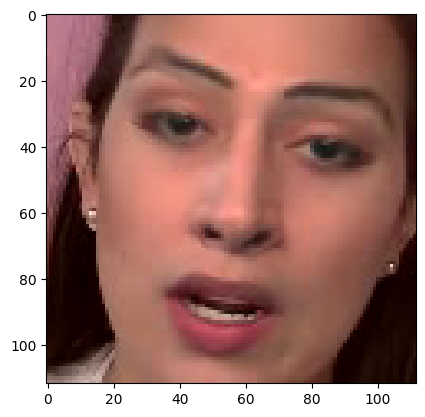

In [9]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/Face_only_data/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 100,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 100,transform = train_transforms)

def custom_collate_fn(batch):
    frames, labels = zip(*batch)
    min_seq_len = min([f.size(0) for f in frames])
    frames = [f[:min_seq_len] for f in frames]
    frames = torch.stack(frames)
    labels = torch.tensor(labels)
    return frames, labels

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4, collate_fn=custom_collate_fn)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4 , collate_fn=custom_collate_fn)
image,label = train_data[0]
im_plot(image[0,:,:,:])


In [10]:
#Model with feature visualization
from torch import nn
from torchvision import models
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        # Load pre-trained weights from ImageNet
        weights = ResNeXt50_32X4D_Weights.IMAGENET1K_V2
        model = resnext50_32x4d(weights=weights)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 92.8MB/s]


In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size


In [12]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))

    return losses.avg,accuracies.avg

In [13]:
import torch
import sys
import os

def test(epoch, model, data_loader, criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()

            _, outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))

            _, p = torch.max(outputs, 1)
            true += targets.type(torch.cuda.LongTensor).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg
                )
            )

        print('\nAccuracy {}'.format(accuracies.avg))

    # Construct the checkpoint filename using test accuracy
    checkpoint_filename = f'test_checkpoint_epoch_{epoch}_acc_{accuracies.avg:.2f}.pt'

    # Save the model state dictionary with the checkpoint filename
    torch.save(model.state_dict(), os.path.join('/content/drive/My Drive/Face_only_data/Trained_Weight5/', checkpoint_filename))

    return true, pred, losses.avg, accuracies.avg


In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

[Epoch 1/20] [Batch 1289 / 1290] [Loss: 0.146128, Acc: 98.76%]Testing
[Batch 214 / 323]  [Loss: 0.415504, Acc: 89.88%]

20


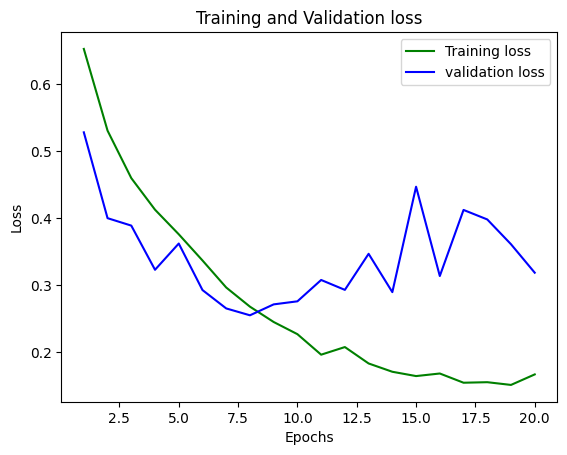

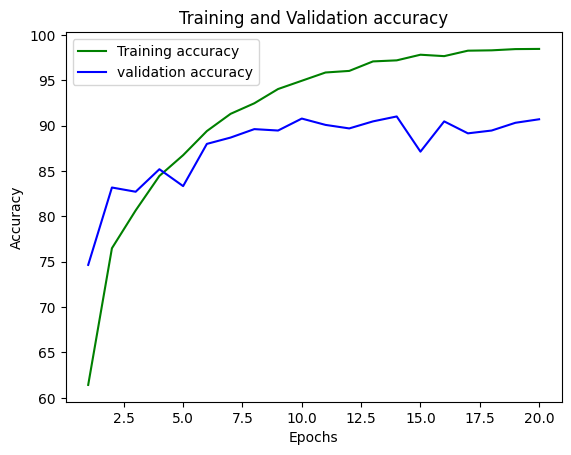

[[559  50]
 [ 70 611]]
True positive =  559
False positive =  50
False negative =  70
True negative =  611




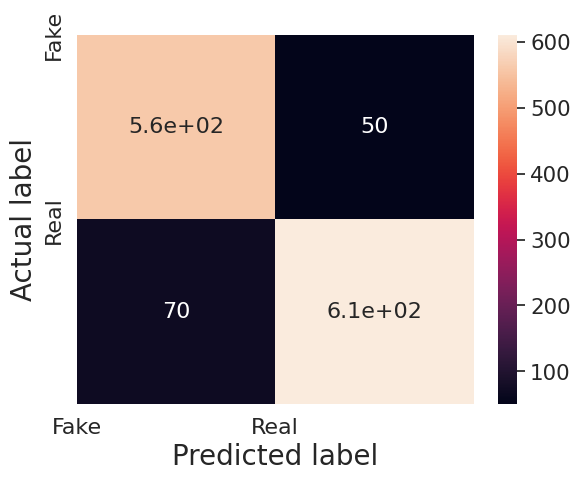

Calculated Accuracy 90.69767441860465


In [15]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)
